## To analyse synthesis and uncertainty

### Set parameters

In [1]:
RUN_ID = 32 # set this to prevent overlapped saving of model and data
INPUT_MODALITY = "T1_T2_FLAIR"
RANDOM_SEED = 0
ROOT_DIR = "/scratch1/sachinsa/cont_syn"
QR_REGRESSION = True

In [2]:
import os
import matplotlib.pyplot as plt

import pdb
import numpy as np
import pickle
from utils.logger import Logger

logger = Logger(log_level='DEBUG')

[INFO] Logging level is: DEBUG


In [3]:
load_dir = os.path.join(ROOT_DIR, f"run_{RUN_ID}")
fig_save_dir_root = os.path.join("..", "figs")
fig_save_dir = os.path.join(fig_save_dir_root, "runs", f"run_{RUN_ID}")
os.makedirs(fig_save_dir, exist_ok=True)

In [4]:
with open(os.path.join(load_dir, 'training_info.pkl'), 'rb') as f:
    training_info = pickle.load(f)
    epoch_loss_values = training_info['epoch_loss_values']
    metric_values = training_info['metric_values']

logger.info("PARAMETERS\n-----------------")
logger.info(f"RUN_ID: {RUN_ID}")
logger.info(f"QR_REGRESSION: {QR_REGRESSION}")
logger.info(f"ROOT_DIR: {ROOT_DIR}")
print("")

[INFO] PARAMETERS
-----------------
[INFO] RUN_ID: 32
[INFO] QR_REGRESSION: True
[INFO] ROOT_DIR: /scratch1/sachinsa/cont_syn



In [5]:
max_epochs = len(epoch_loss_values)
val_interval = len(epoch_loss_values)//len(metric_values)
print("Max epochs:", max_epochs)

Max epochs: 660


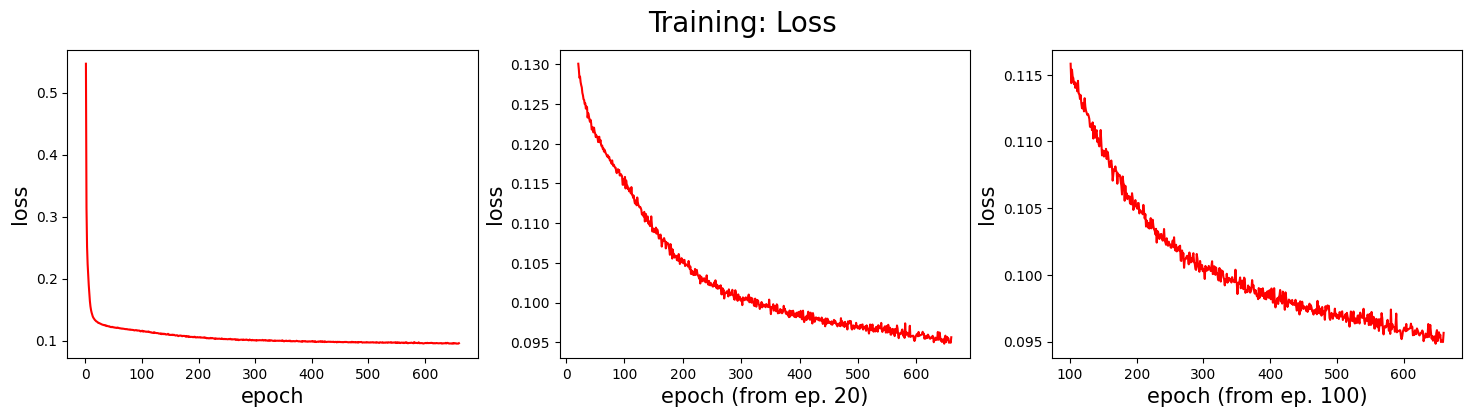

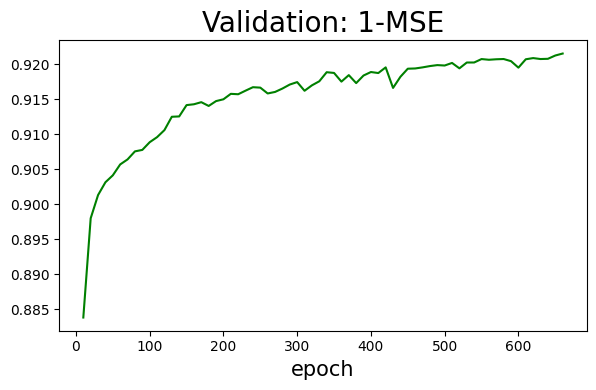

In [6]:
MULTI_TRAINING_FIGURE = True

if not MULTI_TRAINING_FIGURE:
    plt.figure("train", (6, 4))
    x = [i + 1 for i in range(len(epoch_loss_values))]
    y = epoch_loss_values
    plt.xlabel("epoch")
    plt.ylabel("loss - log")
    plt.yscale('log')
    plt.plot(x, y, color="red")
    plt.title("Training: Gaussian Log Likelihood Loss", fontsize=25)
    plt.savefig(os.path.join(fig_save_dir, "train_plot.png"), facecolor='white')
    plt.show()
else:
    plt.figure("train", (18, 4))
    plt.subplot(1, 3, 1)
    x = [i + 1 for i in range(len(epoch_loss_values))]
    y = epoch_loss_values
    plt.xlabel("epoch", fontsize=15)
    plt.ylabel("loss", fontsize=15)
    # plt.ylabel("loss - log", fontsize=15)
    # plt.yscale('log')
    plt.plot(x, y, color="red")
    plt.suptitle("Training: Loss", fontsize=20)

    k = 2
    for zoom in [20, 100]:
        if len(x) > zoom:
            plt.subplot(1, 3, k)
            x = [i + 1 for i in range(len(epoch_loss_values))]
            y = epoch_loss_values
            plt.ylabel("loss", fontsize=15)
            plt.xlabel(f"epoch (from ep. {zoom})", fontsize=15)
            
            plt.plot(x[zoom:], y[zoom:], color="red")
        k += 1
    plt.savefig(os.path.join(fig_save_dir, "train_plot.png"), facecolor='white')
    plt.show()

plt.figure("val", (6, 4))
plt.title("Validation: 1-MSE", fontsize=20)
x_val = [val_interval * (i + 1) for i in range(len(metric_values))]
y_val = metric_values
plt.xlabel("epoch", fontsize=15)
plt.tight_layout()
plt.plot(x_val, y_val, color="green")
plt.savefig(os.path.join(fig_save_dir, "val_plot.png"), facecolor='white')
# plt.ylim([0, 1])
plt.show()

## Inference on the model

In [7]:
import torch

from utils.model import create_UNet3D, inference
from utils.transforms import tumor_seg_transform as data_transform
from utils.dataset import BraTSDataset

In [8]:
input_filter = []
if INPUT_MODALITY == "ONLY_T1":
    input_filter = [1]
elif INPUT_MODALITY == "T1_T2":
    input_filter = [1,3]
elif INPUT_MODALITY == "T1_T2_FLAIR":
    input_filter = [0,1,3]

In [9]:
device = torch.device("cuda:0")
out_channels = 1
model = create_UNet3D(len(input_filter), out_channels, device)

In [10]:
val_dataset = BraTSDataset(
    version='2017',
    section = 'validation',
    seed = RANDOM_SEED,
    transform = data_transform['val']
)

In [11]:
# for id_ in val_dataset.ids:
#     this_input = val_dataset.get_with_id(id_)
#     input_image = this_input["image"].unsqueeze(0).to(device)
#     print(f"{input_image.max().item():.0f}")

this_input = val_dataset.get_with_id(448)
input_image = this_input["image"].unsqueeze(0).to(device)
print(input_image.shape)
print(f"{input_image.max().item():.2f}, {input_image.min().item():.2f}")
print(f"{input_image.mean().item():.2f}, {input_image.var().item():.2f}")

torch.Size([1, 4, 240, 240, 155])
16.13, -6.01
-0.00, 0.15


In [12]:
this_input = val_dataset.get_with_id(429)
input_image = this_input["image"].unsqueeze(0).to(device)
print(input_image.shape)
print(f"{input_image.max().item():.2f}, {input_image.min().item():.2f}")
print(f"{input_image.mean().item():.2f}, {input_image.var().item():.2f}")

torch.Size([1, 4, 240, 240, 155])
10.28, -5.02
-0.00, 0.17


In [19]:
checkpoint = torch.load(os.path.join(load_dir, 'best_checkpoint.pth'), weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
channels = ["FLAIR", "T1w", "T1Gd", "T2w"]
label_list = ["TC", "WT", "ET"]
input_mask = [False, False, True, False]
input_mask = np.array(input_mask)

# interesting ids with tummor: 328, 448

id_ = 60
with torch.no_grad():
    # this_input = val_dataset.get_random()
    this_input = val_dataset.get_with_id(id_)
    # input_image = this_input["image"].unsqueeze(0).to(device)
    # input_image_copy = input_image.clone()
    # input_image_copy[:, input_filter, ...] = 0
    # this_output = inference(input_image_copy, model)


    input_image = this_input["image"].unsqueeze(0).to(device)
    input_image_copy = input_image.clone()
    input_image = input_image[:, input_filter, ...]
    this_output = inference(input_image, model)

In [27]:
# from utils.plot import BrainPlot

import matplotlib.pyplot as plt
from matplotlib.patches import Wedge
import torch
import numpy as np

def plot_donut(value, title, color, ax):
    value = max(0, min(1, value))
    ax.axis("equal")

    radius = 0.7
    inner_radius = 0.5
    angle = 360 * value

    background_circle = Wedge((0, 0), radius, 0, 360, width=radius - inner_radius, color="lightgray")
    ax.add_patch(background_circle)

    active_segment = Wedge((0, 0), radius, 0, angle, width=radius - inner_radius, color=color)
    ax.add_patch(active_segment)

    ax.text(0, 0, f"{value:.0%}", ha="center", va="center", fontsize=20, color="black")
    ax.text(0, 0.85, title, ha="center", va="center", fontsize=20, color="black")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)

def tensor_normalize(tensor):
    mean = tensor.mean()
    std = tensor.std()
    return (tensor - mean) / std

def tensor_clamp(tensor, low=0.01, hi=0.99):
    lower_bound = torch.quantile(tensor, low)
    upper_bound = torch.quantile(tensor, hi)
    return torch.clamp(tensor, min=lower_bound.item(), max=upper_bound.item())

def background_standardize(tensor):
    max_ = tensor.max().item()
    min_ = tensor.min().item()
    tensor[torch.abs(tensor) <  0.03] = min_ # (max_+min_)/2
    return tensor

class BrainPlot():
    def __init__(self, input_image, output_image, input_mask, id, h_index=None, clamp_vis=True):
        self.input_image = input_image
        self.output_image = output_image
        self.input_mask = input_mask
        self.id = id
        im_shape = input_image.shape[2:]
        self.im_length = im_shape[0]
        self.im_width = im_shape[1]
        self.im_height = im_shape[2]
        self.h_index = h_index if h_index is not None else self.im_height//2
        self.clamp_vis = clamp_vis
        self.channels = ["FLAIR", "T1w", "T1Gd", "T2w"]
        self.num_channels = len(self.channels)
        self.total_index = 0

    def t1gd_plot(self, key):
        row_title = ""
        this_input_sub = self.input_image[0, :, :, :, self.h_index]
        this_output_sub = self.output_image[0, :, :, :, self.h_index]
        nc = self.num_channels

        if key == "FLAIR":
            brain_slice = this_input_sub[0]
        elif key == "T1w":
            brain_slice = this_input_sub[1]
        elif key == "T2w":
            brain_slice = this_input_sub[3]
        elif key == "T1Gd":
            brain_slice = this_input_sub[2]
        elif key == "T1Gd-synth":
            brain_slice = this_output_sub[0]

        plt.subplot(1, 5, 1+self.total_index)
        self.total_index += 1

        brain_slice = brain_slice.detach().cpu().T
        # brain_slice = torch.flip(brain_slice, dims=[0])
        # if brain_slice.dtype != torch.bool:
        #     if self.clamp_vis:
        #         brain_slice = tensor_clamp(brain_slice)
            # brain_slice = background_standardize(brain_slice)

        col_title = key
        plt.title(col_title, fontsize=30)

        plt.imshow(brain_slice, cmap="gray")
        plt.xlabel('')
        plt.suptitle(f"BRATS_{self.id} (h={self.h_index}/{self.im_height})", fontsize=20)
        plt.xticks([self.im_width - 1], [self.im_width], fontsize=15)
        plt.yticks([self.im_length - 1], [self.im_length], fontsize=15)
        # plt.colorbar()
        plt.tight_layout()
        # cbar = plt.colorbar(shrink=0.7)
        # cbar.ax.tick_params(labelsize=20)



    def plot(self, key):
        index = self.total_index%self.num_channels
        row_title = ""
        this_input_sub = self.input_image[0, :, :, :, self.h_index]
        this_output_sub = self.output_image[0, :, :, :, self.h_index]
        nc = self.num_channels

        if key == "input":
            row_title = "Input"
            brain_slice = this_input_sub[index]
        elif key == "q0":
            row_title = "Output: \n" + "Median"
            brain_slice = this_output_sub[index]
        elif key == "q1":
            row_title = "Output: \n" + r"qL" + ""
            brain_slice = this_output_sub[index+1*nc]
        elif key == "q2":
            row_title = "Output: \n" + r"qH" + ""
            brain_slice = this_output_sub[index+2*nc]
        elif key == "q3":
            row_title = "Outlier"
            lower_slice = this_input_sub[index] < this_output_sub[index+nc]
            upper_slice = this_input_sub[index] > this_output_sub[index+2*nc]
            brain_slice = torch.logical_or(lower_slice, upper_slice)
        elif key == "diff":
            row_title = "Diff"
            brain_slice = this_input_sub[index]-this_output_sub[index]
        num_rows = 5
        
        plt.subplot(num_rows, 4, 1+self.total_index)
        self.total_index += 1

        col_title = self.channels[index]
        col_color = "red" if self.input_mask[index] else "green"
        if key == "input":
            plt.title(col_title, fontsize=30, color=col_color)
        brain_slice = brain_slice.detach().cpu().T
        brain_slice = torch.flip(brain_slice, dims=[0]) # flip horizontally

        if brain_slice.dtype != torch.bool:
            if self.clamp_vis:
                brain_slice = tensor_clamp(brain_slice)
            brain_slice = background_standardize(brain_slice)

        plt.imshow(brain_slice, cmap="gray")

        plt.xlabel('')
        if index == 0:
            plt.ylabel(row_title, fontsize=30)

        plt.suptitle(f"BRATS_{self.id} (h={self.h_index}/{self.im_height})", fontsize=20)
        plt.xticks([self.im_width - 1], [self.im_width], fontsize=15)
        plt.yticks([self.im_length - 1], [self.im_length], fontsize=15)
        plt.tight_layout()
        cbar = plt.colorbar(shrink=0.7)
        cbar.ax.tick_params(labelsize=20)


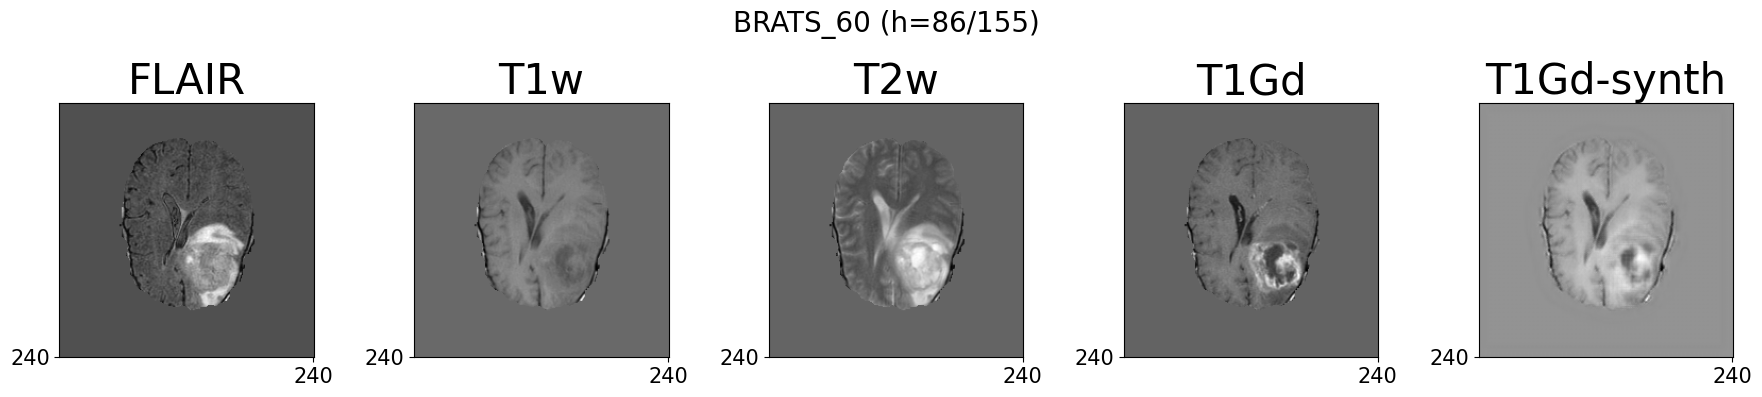

In [28]:
plt.figure("image", (18, 4))
b_plot = BrainPlot(input_image_copy, this_output, input_mask, h_index=86, id=id_)

b_plot.t1gd_plot("FLAIR")
b_plot.t1gd_plot("T1w")
b_plot.t1gd_plot("T2w")
b_plot.t1gd_plot("T1Gd")
b_plot.t1gd_plot("T1Gd-synth")

# for i in range(4):
#     b_plot.plot("input")
# for i in range(4):
#     b_plot.plot("q0")
# for i in range(4):
#     b_plot.plot("q1")
# for i in range(4):
#     b_plot.plot("q2")
plt.savefig(os.path.join(fig_save_dir_root, "results", f"brats_{id_}.png"), facecolor='white')

### Evaluation metrics

In [29]:
from monai.data import DataLoader
import torch.nn.functional as torch_F
from torchmetrics.functional import structural_similarity_index_measure

def compute_ssim(predicted, ground):
    return structural_similarity_index_measure(predicted, ground, data_range=ground.max() - ground.min()).item()

def filter_with_mask(data, mask):
    return data[:, mask, ...]


In [30]:
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=4)
print(len(val_dataset.get_ids()))

97


In [31]:
# def evaluate_metric(is_masked):
#     ssim_list = []
#     psnr_list = []

#     model.eval()
#     i = 0
#     with torch.no_grad():
#         for this_input in val_loader:
#             i+=1
#             if i > 10: break
#             this_input_image = this_input["image"].to(device)
#             this_groundtruth = this_input_image.clone()[:, [2], ...] # T1Gd
#             this_input_image = this_input_image[:,input_filter, ...]
#             this_predicted = inference(this_input_image, model)

#             ssim_list.append(
#                 compute_ssim(this_predicted, this_groundtruth)
#             )

#             mse_loss_val = torch_F.mse_loss(this_predicted, this_groundtruth)
#             peak_signal_value = torch.max(this_groundtruth) - torch.min(this_groundtruth)
#             psnr_score = 20 * torch.log10(peak_signal_value / torch.sqrt(mse_loss_val))
#             psnr_list.append(psnr_score.item())

#     return np.mean(psnr_list), np.mean(ssim_list)

# psnr_score, ssim_score = evaluate_metric(is_masked=None)
# print("Overall score:")
# print(f"PSNR: {psnr_score:.1f}")
# print(f"SSIM: {ssim_score:.3f}")